In [31]:
import pandas as pd
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

In [32]:
def normalize_date(date: str):
    date = date.split('/')
    if date[1].startswith('0'):
        date[1] = date[1][1:]
    if len(date[2]) == 2:
        date[2] = '20' + date[2]
    return '/'.join(date)

In [33]:
data = pd.read_csv('ci_data.csv').drop('RefNo', axis=1)
data = data.dropna()
data['Date'] = pd.to_datetime(data['Date'].apply(normalize_date), format='%d/%m/%Y')

display(data[data['Deposit']>0][data['Category'] != 'Misc'].head(10))

C:\Users\Micha\AppData\Local\Temp\ipykernel_15588\1176054545.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(data[data['Deposit']>0][data['Category'] != 'Misc'].head(10))


,Date,Category,Date.1,Withdrawal,Deposit,Balance
118,2023-01-25,Salary,25/01/23,0.0,34800.0,36119.74
217,2023-02-11,Shopping,11/2/2023,0.0,249.0,2035.82
218,2023-02-11,Shopping,11/2/2023,0.0,225.0,2260.82
287,2023-02-24,Salary,24/02/23,0.0,34800.0,34818.89
419,2023-03-24,Salary,24/03/23,0.0,34800.0,34866.26
500,2023-04-05,Shopping,5/4/2023,0.0,54.0,3742.79
608,2023-04-24,Food,24/04/23,0.0,292.4,1100.57
611,2023-04-25,Salary,25/04/23,0.0,34800.0,35665.82
632,2023-04-27,Shopping,27/04/23,0.0,400.0,18764.82
733,2023-05-10,Food,10/5/2023,0.0,10.0,3505.36


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

# Загрузка данных
df = pd.read_csv("ci_data.csv")

# Предобработка данных: удаление строк с пропущенными значениями
df = df.dropna()

# Предобработка данных: Преобразование столбца Date в формат datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Кодирование категориальных переменных
df['Category'] = df['Category'].astype('category')
df['Category_Code'] = df['Category'].cat.codes

# Подготовка данных для модели
X = df[['Withdrawal', 'Deposit', 'Balance']]
y = df['Category_Code']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Анализ количества экземпляров для каждой категории в обучающем наборе
category_counts = y_train.value_counts()
print("Количество экземпляров для каждой категории до обработки:", category_counts)

# Определение минимального количества экземпляров в категории
min_samples = category_counts.min()

# Установка n_neighbors в SMOTE в зависимости от min_samples
n_neighbors = min(min_samples - 1, 5)  # Установите 5 или меньше, но не больше min_samples - 1

# Проверка, что n_neighbors > 0
if n_neighbors <= 0:
    raise ValueError("Невозможно использовать SMOTE, так как в некоторых категориях недостаточно образцов.")

# Обработка дисбаланса классов с помощью SMOTE
smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Проверка баланса классов после SMOTE
print("Баланс классов после SMOTE:", Counter(y_train_smote))

# Инициализация CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,  # Количество итераций
    learning_rate=0.1,  # Скорость обучения
    depth=6,  # Глубина дерева
    loss_function='MultiClass',  # Функция потерь для многоклассовой классификации
    eval_metric='Accuracy',  # Метрика оценки
    random_seed=42,
    verbose=False  # Отключение вывода информации об обучении
)

# Обучение модели CatBoost
model.fit(X_train_smote, y_train_smote)

# Оценка модели
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['Category'].cat.categories))

# Определение минимального количества экземпляров в каждой категории
min_samples = df['Category'].value_counts().min()

# Подготовка к генерации новых данных
num_categories = len(df['Category'].unique())
n_to_generate = 10000

# Расчет количества строк для генерации для каждой категории
rows_per_category = n_to_generate // num_categories

# Функция для генерации синтетических данных на основе обученной модели
def generate_synthetic_data(model, num_samples, feature_names=['Withdrawal', 'Deposit', 'Balance']):
    generated_data = []
    for _ in range(num_samples):
        # Генерация случайных значений для Withdrawal, Deposit и Balance в диапазоне обучающих данных
        withdrawal = np.random.uniform(df['Withdrawal'].min(), df['Withdrawal'].max())
        deposit = np.random.uniform(df['Deposit'].min(), df['Deposit'].max())
        balance = np.random.uniform(df['Balance'].min(), df['Balance'].max())

        # Предсказание категории с использованием обученной модели
        predicted_category_code = model.predict(np.array([[withdrawal, deposit, balance]]))[0]

        # Декодирование предсказанной категории
        predicted_category = df['Category'].cat.categories[predicted_category_code][0]

        generated_data.append({
            'Date': pd.to_datetime('2024-01-01'),  # Заглушка для даты
            'Category': predicted_category,
            'RefNo': 0,  # Генерация случайного RefNo
            'Withdrawal': withdrawal,
            'Deposit': deposit,
            'Balance': balance
        })
    return pd.DataFrame(generated_data)

# Генерация сбалансированных синтетических данных
generated_df = generate_synthetic_data(model, n_to_generate)

# Вывод информации о сгенерированных данных
print("Сгенерированный DataFrame:")
print(generated_df.head())
print("\nРазмер сгенерированного DataFrame:", generated_df.shape)
print("\nСоотношение категорий в сгенерированном DataFrame:")
print(generated_df['Category'].value_counts())

# Конкатенация с исходным DataFrame
balanced_df = pd.concat([df[['Date', 'Category', 'RefNo', 'Withdrawal', 'Deposit', 'Balance']], generated_df], ignore_index=True)

print("\nРазмер объединенного DataFrame:", balanced_df.shape)
print("\nСоотношение категорий в объединенном DataFrame:")
print(balanced_df['Category'].value_counts())


start_date = '2024-01-01'  # Начальная дата
end_date = '2024-01-31'    # Конечная дата
date_range = pd.date_range(start=start_date, periods=len(balanced_df), freq='D')
balanced_df['Date'] = date_range

# Экспорт в новый CSV файл
balanced_df.to_csv('balanced_data_catboost.csv', index=False)


Количество экземпляров для каждой категории до обработки: Category_Code
0    738
1    396
4     26
3      8
2      5
5      2
Name: count, dtype: int64
Баланс классов после SMOTE: Counter({0: 738, 1: 738, 4: 738, 3: 738, 2: 738, 5: 738})


c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

        Food       0.99      0.93      0.96       174
        Misc       0.84      0.89      0.87       109
        Rent       0.50      0.50      0.50         2
      Salary       0.67      1.00      0.80         2
    Shopping       0.09      0.17      0.12         6
   Transport       0.00      0.00      0.00         1

    accuracy                           0.89       294
   macro avg       0.52      0.58      0.54       294
weighted avg       0.91      0.89      0.90       294



<Axes: >

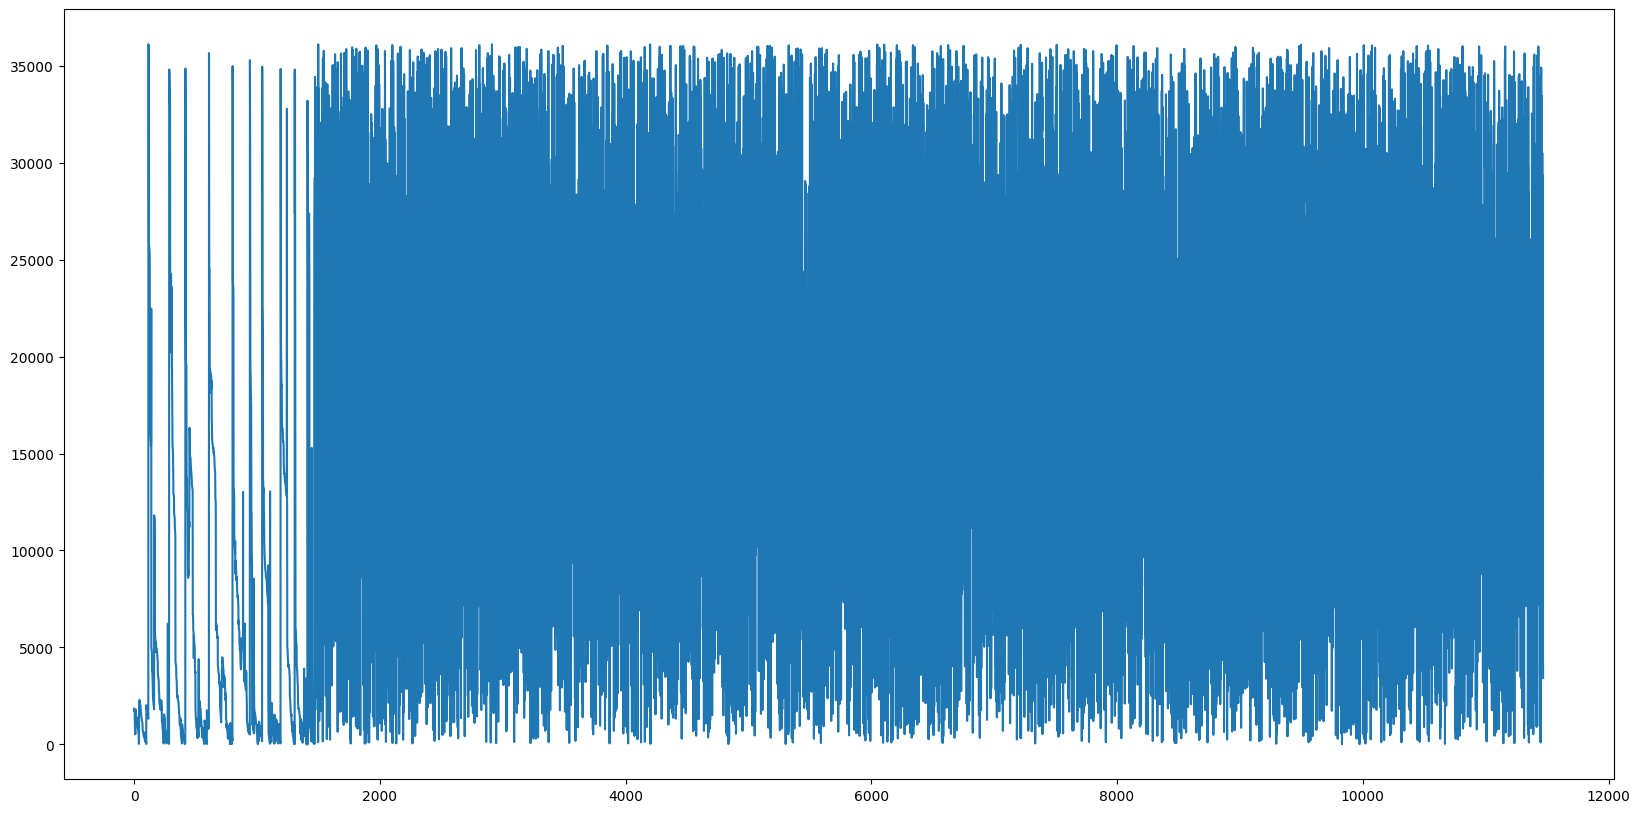

In [ ]:
plt.figure(figsize=(20, 10))
balanced_df['Balance'].plot()

c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


1469    673.462024
dtype: float64


c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Micha\Documents\finasist\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


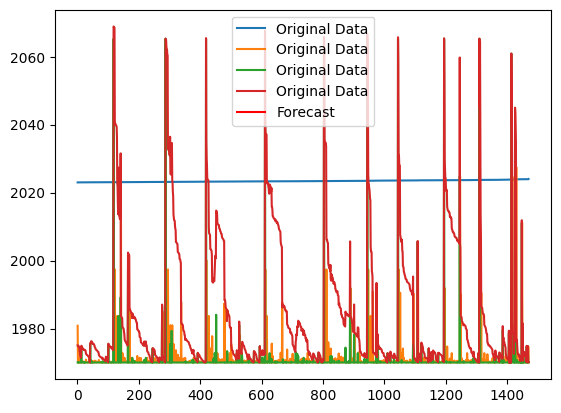

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

df = data
df = df.drop('Date.1', axis=1)
df = df.drop('Category', axis=1)

# Fit ARIMA model (example: ARIMA(2, 1, 2))
model = ARIMA(df['Withdrawal'], order=(2, 1, 2))
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=1)
print(forecast)

# Plot original data and forecast
plt.plot(df, label="Original Data")
plt.plot(forecast, label="Forecast", color='red')
plt.legend()
plt.show()


In [23]:
import pandas as pd
import numpy as np
import random

# Загрузка данных из CSV-файла
df = pd.read_csv('ci_data.csv')

# Удалите первую строку с Date, Category, RefNo, Date, Withdrawal, Deposit, Balance
df = df.iloc[1:]

# Удалите столбец RefNo
df = df.drop('RefNo', axis=1)

# Преобразование столбца "Date" в тип datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Удаление строк с пропущенными значениями в столбце "Date"
df = df.dropna(subset=['Date'])

# Преобразование столбцов "Withdrawal", "Deposit" и "Balance" в числовой тип
df['Withdrawal'] = pd.to_numeric(df['Withdrawal'], errors='coerce')
df['Deposit'] = pd.to_numeric(df['Deposit'], errors='coerce')
df['Balance'] = pd.to_numeric(df['Balance'], errors='coerce')

# Заполнение пропущенных значений нулями
df = df.fillna(0)

# Установка столбца "Date" в качестве индекса
df = df.set_index('Date')

# Функция для добавления шума и сдвига к данным
def add_noise_and_shift(df, year, withdrawal_noise_scale=0.2, deposit_noise_scale=0.2, balance_shift=0.2):
    df = df.copy()
    # Добавление шума к столбцам "Withdrawal" и "Deposit"
    df['Withdrawal'] = df['Withdrawal'] * (1 + np.random.normal(0, random.randint(1, 100)/100, len(df)))
    df['Deposit'] = df['Deposit'] * (1 + np.random.normal(0, random.randint(1, 100)/100, len(df)))

    # Сдвиг столбца "Balance"
    df['Balance'] = df['Balance'] * (1 + random.randint(1, 100)/100)

    # Изменение года в индексе Date
    df.index = df.index.map(lambda d: d.replace(year=year))

    return df

# Определение количества лет для генерации
num_years = 3

# Создание списка для хранения сгенерированных DataFrame
dfs = [df]

# Генерация данных на каждый год
for i in range(0, num_years + 1):
    year = df.index.max().year + i
    new_df = add_noise_and_shift(df, year)
    dfs.append(new_df)

# Объединение всех DataFrame
combined_df = pd.concat(dfs)

# Сортировка по дате
combined_df = combined_df.sort_index()

# combined_df = combined_df.drop(combined_df.index[combined_df.index.year == 2024])

# Вывод комбинированного DataFrame
combined_df['Withdrawal'] = combined_df['Withdrawal'].abs()
combined_df['Balance'] = combined_df['Balance'].abs()
combined_df['Deposit'] = combined_df['Deposit'].abs()

combined_df = combined_df.reset_index()
combined_df['Date'] = combined_df['Date'].apply(lambda x: x.strftime('%d/%m/%Y'))


combined_df['Date.1'] = combined_df['Date']
combined_df['RefNo'] = 1

print(combined_df)


            Date   Category      Date.1   Withdrawal      Deposit   Balance  \
0     01/01/2023       Rent  01/01/2023  3950.000000     0.000000  1837.230   
1     03/01/2023       Misc  03/01/2023   105.000000     0.000000  1732.230   
2     03/01/2023       Misc  03/01/2023     0.000000    55.000000  1787.230   
3     03/01/2023       Food  03/01/2023    56.000000     0.000000  1731.230   
4     03/01/2023       Misc  03/01/2023     1.000000     0.000000  1730.230   
...          ...        ...         ...          ...          ...       ...   
2840  12/12/2027       Food  12/12/2027    29.050516     0.000000  1243.476   
2841  12/12/2027       Misc  12/12/2027    82.363505     0.000000   209.976   
2842  12/12/2027       Food  12/12/2027    55.256543     0.000000   141.726   
2843  12/12/2027       Misc  12/12/2027     0.000000  2007.337942  3491.826   
2844  12/12/2027  Transport  12/12/2027  1639.804007     0.000000   141.726   

      RefNo  
0         1  
1         1  
2        

'01/01/2023'

In [24]:
combined_df.to_csv('noise_data.csv')

<Axes: xlabel='Date'>

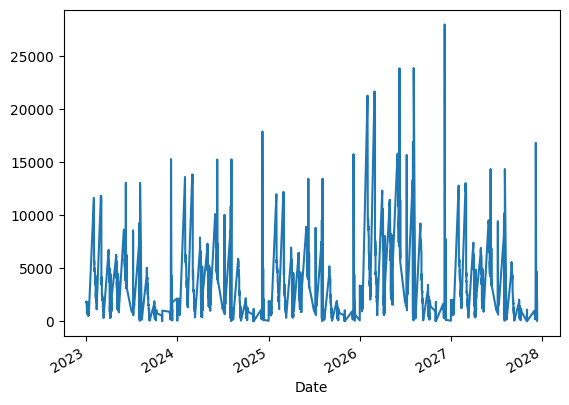

In [14]:
combined_df['Balance'].plot()

In [ ]:
import pandas as pd
import numpy as np
import random

# Загрузка данных из CSV-файла
df = pd.read_csv('ci_data.csv')

# Удалите первую строку с Date, Category, RefNo, Date, Withdrawal, Deposit, Balance
df = df.iloc[1:]

# Удалите столбец RefNo
df = df.drop('RefNo', axis=1)

# Преобразование столбца "Date" в тип datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Удаление строк с пропущенными значениями в столбце "Date"
df = df.dropna(subset=['Date'])

# Преобразование столбцов "Withdrawal", "Deposit" и "Balance" в числовой тип
df['Withdrawal'] = pd.to_numeric(df['Withdrawal'], errors='coerce')
df['Deposit'] = pd.to_numeric(df['Deposit'], errors='coerce')
df['Balance'] = pd.to_numeric(df['Balance'], errors='coerce')

# Заполнение пропущенных значений нулями
df = df.fillna(0)

# Установка столбца "Date" в качестве индекса
df = df.set_index('Date')

# Функция для добавления шума и сдвига к данным
def add_noise_and_shift(df, year):
    df = df.copy()
    
    # Генерация случайных масштабов шума для каждого столбца
    withdrawal_noise_scale = random.uniform(0.2, 0.5)
    deposit_noise_scale = random.uniform(0.2, 0.5)
    balance_shift = random.uniform(0.2, 0.5)
    
    # Добавление шума к столбцам "Withdrawal" и "Deposit"
    df['Withdrawal'] = df['Withdrawal'] * (1 + np.random.normal(0, withdrawal_noise_scale, len(df)))
    df['Deposit'] = df['Deposit'] * (1 + np.random.normal(0, deposit_noise_scale, len(df)))

    # Сдвиг столбца "Balance"
    df['Balance'] = df['Balance'] * (1 + balance_shift)

    # Изменение года в индексе Date
    df.index = df.index.map(lambda d: d.replace(year=year))

    return df

# Функция для балансировки категорий
def balance_categories(df, target_count):
    category_counts = df['Category'].value_counts()
    dfs = []
    for category, count in category_counts.items():
        if count < target_count:
            # Дополняем категорию до target_count, дублируя случайные строки
            category_df = df[df['Category'] == category].copy()
            num_needed = target_count - count
            if not category_df.empty:
                duplicated_rows = category_df.sample(n=num_needed, replace=True)
                dfs.append(duplicated_rows)
    
    if dfs:
        df = pd.concat([df] + dfs, ignore_index=True)
    
    return df

# Определение количества лет для генерации
num_years = 3

# Создание списка для хранения сгенерированных DataFrame
dfs = [df.reset_index()]  # Reset index перед добавлением в список

# Генерация данных на каждый год
for i in range(0, num_years + 1):
    year = df.index.max().year + i
    new_df = add_noise_and_shift(df, year).reset_index()  # Reset index после add_noise_and_shift
    dfs.append(new_df)

# Объединение всех DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Сортировка по дате
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df.sort_values(by='Date')

# Балансировка категорий
target_count = combined_df['Category'].value_counts().max()
combined_df = balance_categories(combined_df, target_count)

# Вывод комбинированного DataFrame
combined_df['Withdrawal'] = combined_df['Withdrawal'].abs()
combined_df['Balance'] = combined_df['Balance'].abs()
combined_df['Deposit'] = combined_df['Deposit'].abs()

combined_df['Date'] = combined_df['Date'].apply(lambda x: x.strftime('%d/%m/%Y'))

# Добавление столбца RefNo и копии даты
combined_df['Date.1'] = combined_df['Date']
combined_df['RefNo'] = 1

print(combined_df)



            Date   Category      Date.1   Withdrawal  Deposit      Balance  \
0     01/01/2023       Rent  01/01/2023  3950.000000      0.0  1837.230000   
1     03/01/2023       Misc  03/01/2023   105.000000      0.0  1732.230000   
2     03/01/2023       Misc  03/01/2023     0.000000     55.0  1787.230000   
3     03/01/2023       Food  03/01/2023    56.000000      0.0  1731.230000   
4     03/01/2023       Misc  03/01/2023     1.000000      0.0  1730.230000   
...          ...        ...         ...          ...      ...          ...   
8895  12/12/2023  Transport  12/12/2023  1718.000000      0.0    72.680000   
8896  10/12/2025  Transport  10/12/2025  2743.119738      0.0  1441.650446   
8897  10/12/2027  Transport  10/12/2027  2771.684025      0.0  1585.239201   
8898  10/12/2023  Transport  10/12/2023  3062.000000      0.0  1181.970000   
8899  10/12/2026  Transport  10/12/2026  2827.310262      0.0  1419.256657   

      RefNo  
0         1  
1         1  
2         1  
3      

<Axes: >

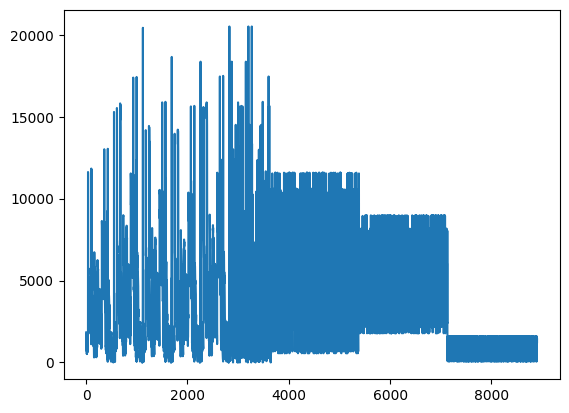

In [12]:
combined_df['Balance'].plot()

In [13]:
combined_df.to_csv('noise_bal_data.csv')

In [65]:
json_data = [
    {
  "id": "0bbc34c5-93c2-409c-90ec-69f35aff9e04",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-02T00:00:00",
  "receipt_date": "2025-03-02T00:00:00",
  "withdraw": "0",
  "deposit": "121.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "21438.6599999999967985786498",
  "created_at": "2025-04-06T10:28:24.275467",
  "expediency": 0
},
{
  "id": "b14f4ad1-f333-4ce5-9162-bc32dfc7dae4",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-02T00:00:00",
  "receipt_date": "2025-03-02T00:00:00",
  "withdraw": "1350.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "21317.6599999999967985786498",
  "created_at": "2025-04-06T10:28:24.275421",
  "expediency": 0
},
{
  "id": "10afc5f0-a0fc-4848-94dd-863716744026",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "42.69",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "22667.6599999999967985786498",
  "created_at": "2025-04-06T10:28:24.275376",
  "expediency": 0
},
{
  "id": "4200dd47-923c-44d5-ac90-2cbf4c947a1c",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "313.67",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "22710.3499999999967985786498",
  "created_at": "2025-04-06T10:28:24.275331",
  "expediency": 0
},
{
  "id": "091d2d3c-3f01-4bfa-b99e-1fa79ae15112",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "300.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23024.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.275286",
  "expediency": 0
},
{
  "id": "e8834c3d-825b-4f09-8cf8-1c281d8f3cd4",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23324.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.275241",
  "expediency": 0
},
{
  "id": "a09ac159-43c6-4593-b53f-478950a337a3",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "170.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23359.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.275191",
  "expediency": 0
},
{
  "id": "b3e44765-429d-4b89-b8d9-0feda2c91b3f",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "135.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23529.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.275146",
  "expediency": 0
},
{
  "id": "db21a1a2-d4c4-46d4-8f61-90ce121b1612",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "195.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23664.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.275100",
  "expediency": 0
},
{
  "id": "5543260e-9a8d-4832-b121-23ea04a64c4b",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "0",
  "deposit": "105.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23859.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.275052",
  "expediency": 0
},
{
  "id": "7d33bbaf-dbd7-4767-9887-29931a5fbfb5",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-03-01T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "0",
  "deposit": "64.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23754.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.275006",
  "expediency": 0
},
{
  "id": "23e6aed4-5112-40df-b049-5af5e181045b",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-28T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "604.86",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "23690.0199999999967985786498",
  "created_at": "2025-04-06T10:28:24.274960",
  "expediency": 0
},
{
  "id": "cf72cdeb-6306-4dbf-a779-fb52ea25cfcd",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-28T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "0",
  "deposit": "100.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "44294.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274860",
  "expediency": 0
},
{
  "id": "0683b38b-74be-43eb-a4b9-846237935674",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-28T00:00:00",
  "receipt_date": "2025-03-01T00:00:00",
  "withdraw": "575.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "44194.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274814",
  "expediency": 0
},
{
  "id": "ad31c243-827e-4a79-a042-3e9b1bcdda3b",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-28T00:00:00",
  "receipt_date": "2025-02-28T00:00:00",
  "withdraw": "199.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "21239.6599999999967985786498",
  "created_at": "2025-04-06T10:28:24.275512",
  "expediency": 0
},
{
  "id": "a9855946-ab9b-4b8a-894c-3abf92bcc907",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-28T00:00:00",
  "receipt_date": "2025-02-28T00:00:00",
  "withdraw": "20000.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "24294.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274906",
  "expediency": 0
},
{
  "id": "2e55a29e-9a68-4bc6-a7f5-5ebe0052b227",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-28T00:00:00",
  "receipt_date": "2025-02-28T00:00:00",
  "withdraw": "314.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "44769.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274766",
  "expediency": 0
},
{
  "id": "4c17e09a-34b7-4286-ba14-000b4fb40581",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-27T00:00:00",
  "receipt_date": "2025-02-28T00:00:00",
  "withdraw": "104.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45083.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274720",
  "expediency": 0
},
{
  "id": "1ae5902d-3b81-42df-b16a-179920273265",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-27T00:00:00",
  "receipt_date": "2025-02-28T00:00:00",
  "withdraw": "7145.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45187.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274675",
  "expediency": 0
},
{
  "id": "9fffa0ca-3d5d-4457-bc97-02946d80f18e",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-27T00:00:00",
  "receipt_date": "2025-02-28T00:00:00",
  "withdraw": "0",
  "deposit": "1782.50",
  "processing_status": "in_progress",
  "category": None,
  "balance": "53206.3599999999967985786498",
  "created_at": "2025-04-06T10:28:24.274469",
  "expediency": 0
},
{
  "id": "22c88822-cff0-4870-ab61-1ffd2859ad73",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-27T00:00:00",
  "receipt_date": "2025-02-28T00:00:00",
  "withdraw": "0",
  "deposit": "1483.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "51423.8599999999967985786498",
  "created_at": "2025-04-06T10:28:24.274422",
  "expediency": 0
},
{
  "id": "e55c29cd-46a1-464e-bc1c-3aad354faae7",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-27T00:00:00",
  "receipt_date": "2025-02-27T00:00:00",
  "withdraw": "104.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "52332.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274629",
  "expediency": 0
},
{
  "id": "c4a7b0d8-9d9b-44dd-8ac1-e1650fb0494d",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-27T00:00:00",
  "receipt_date": "2025-02-27T00:00:00",
  "withdraw": "169.48",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "52436.8799999999967985786498",
  "created_at": "2025-04-06T10:28:24.274578",
  "expediency": 0
},
{
  "id": "8c892821-1154-4a35-954d-3e8029edcf16",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-27T00:00:00",
  "receipt_date": "2025-02-27T00:00:00",
  "withdraw": "600.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "52606.3599999999967985786498",
  "created_at": "2025-04-06T10:28:24.274517",
  "expediency": 0
},
{
  "id": "c76d8cd0-079b-4e44-8314-706671fdd87f",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-26T00:00:00",
  "receipt_date": "2025-02-26T00:00:00",
  "withdraw": "133.96",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "49940.8599999999967985786498",
  "created_at": "2025-04-06T10:28:24.274375",
  "expediency": 0
},
{
  "id": "57b691c6-7a29-48d1-890d-75496aa25680",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-26T00:00:00",
  "receipt_date": "2025-02-26T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "50074.8199999999967985786498",
  "created_at": "2025-04-06T10:28:24.274297",
  "expediency": 0
},
{
  "id": "e0434a18-19c2-4f1f-9d3b-7187728aa240",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-26T00:00:00",
  "receipt_date": "2025-02-26T00:00:00",
  "withdraw": "250.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "50109.8199999999967985786498",
  "created_at": "2025-04-06T10:28:24.274251",
  "expediency": 0
},
{
  "id": "f03970f7-b1a7-4525-9164-4401ca3bb2e9",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-26T00:00:00",
  "receipt_date": "2025-02-26T00:00:00",
  "withdraw": "185.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "50359.8199999999967985786498",
  "created_at": "2025-04-06T10:28:24.274206",
  "expediency": 0
},
{
  "id": "db812bff-493c-4b3d-8f9b-4ee311600d5c",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-26T00:00:00",
  "receipt_date": "2025-02-26T00:00:00",
  "withdraw": "57.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "50544.8199999999967985786498",
  "created_at": "2025-04-06T10:28:24.274162",
  "expediency": 0
},
{
  "id": "ce74e0e4-0ce5-4774-bcdf-0da40fe34b5b",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-25T00:00:00",
  "receipt_date": "2025-02-25T00:00:00",
  "withdraw": "94.99",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "50601.8199999999967985786498",
  "created_at": "2025-04-06T10:28:24.274117",
  "expediency": 0
},
{
  "id": "f55c176e-bba4-4326-8eb1-1d5ce26e9eca",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-25T00:00:00",
  "receipt_date": "2025-02-25T00:00:00",
  "withdraw": "350.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "50696.8099999999967985786498",
  "created_at": "2025-04-06T10:28:24.274072",
  "expediency": 0
},
{
  "id": "2fff9693-b04a-499d-8f31-032ca1ad4a04",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-24T00:00:00",
  "receipt_date": "2025-02-25T00:00:00",
  "withdraw": "362.66",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "51046.8099999999967985786498",
  "created_at": "2025-04-06T10:28:24.274027",
  "expediency": 0
},
{
  "id": "4dbb64c0-2e6b-425b-bcaa-e1b91a3a4fbb",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-24T00:00:00",
  "receipt_date": "2025-02-24T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "51409.4699999999967985786498",
  "created_at": "2025-04-06T10:28:24.273982",
  "expediency": 0
},
{
  "id": "6f274e39-1b3c-43c2-8cea-1f59f14218a9",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-24T00:00:00",
  "receipt_date": "2025-02-24T00:00:00",
  "withdraw": "86.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "51444.4699999999967985786498",
  "created_at": "2025-04-06T10:28:24.273937",
  "expediency": 0
},
{
  "id": "f08ade6a-aae6-4054-92ac-d86a1cbd4047",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-24T00:00:00",
  "receipt_date": "2025-02-24T00:00:00",
  "withdraw": "275.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "51530.4699999999967985786498",
  "created_at": "2025-04-06T10:28:24.273892",
  "expediency": 0
},
{
  "id": "c48d53b8-341b-4602-8f59-5b4479d51a14",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-23T00:00:00",
  "receipt_date": "2025-02-23T00:00:00",
  "withdraw": "196.98",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "51805.4699999999967985786498",
  "created_at": "2025-04-06T10:28:24.273845",
  "expediency": 0
},
{
  "id": "1d926d67-398b-47d1-8c99-8f19fb882bce",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-23T00:00:00",
  "receipt_date": "2025-02-23T00:00:00",
  "withdraw": "235.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "52002.4499999999967985786498",
  "created_at": "2025-04-06T10:28:24.273797",
  "expediency": 0
},
{
  "id": "74836733-0077-47bd-8282-cb3d308ad74a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-22T00:00:00",
  "receipt_date": "2025-02-23T00:00:00",
  "withdraw": "495.96",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "52237.4499999999967985786498",
  "created_at": "2025-04-06T10:28:24.273752",
  "expediency": 0
},
{
  "id": "bfda03c3-7669-4c5c-a4fa-481cf1d8fd22",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-22T00:00:00",
  "receipt_date": "2025-02-22T00:00:00",
  "withdraw": "198.68",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "52733.4099999999967985786498",
  "created_at": "2025-04-06T10:28:24.273707",
  "expediency": 0
},
{
  "id": "f0ca3408-cefd-40c2-90f8-494f677e8c3c",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-22T00:00:00",
  "receipt_date": "2025-02-22T00:00:00",
  "withdraw": "300.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "52932.0899999999967985786498",
  "created_at": "2025-04-06T10:28:24.273658",
  "expediency": 0
},
{
  "id": "ef2b0a2a-399a-41f1-833d-aa3ee10e64aa",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-21T00:00:00",
  "receipt_date": "2025-02-22T00:00:00",
  "withdraw": "750.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "54372.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273357",
  "expediency": 0
},
{
  "id": "15fdfa63-5127-4273-8810-5568c031a882",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-21T00:00:00",
  "receipt_date": "2025-02-21T00:00:00",
  "withdraw": "383.07",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "53232.0899999999967985786498",
  "created_at": "2025-04-06T10:28:24.273605",
  "expediency": 0
},
{
  "id": "8522db34-ec5e-42d5-8e88-b890e39f4219",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-21T00:00:00",
  "receipt_date": "2025-02-21T00:00:00",
  "withdraw": "193.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "53615.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273550",
  "expediency": 0
},
{
  "id": "ad73e012-b989-4b0a-9baf-410bd7821945",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-21T00:00:00",
  "receipt_date": "2025-02-21T00:00:00",
  "withdraw": "130.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "53808.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273504",
  "expediency": 0
},
{
  "id": "cf99a544-659f-4ca7-98d7-9c18da880f8e",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-21T00:00:00",
  "receipt_date": "2025-02-21T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "53938.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273455",
  "expediency": 0
},
{
  "id": "73aa0f84-637f-409a-9668-f8cff3adbb2a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-21T00:00:00",
  "receipt_date": "2025-02-21T00:00:00",
  "withdraw": "399.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "53973.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273405",
  "expediency": 0
},
{
  "id": "5665d03c-f9de-4d89-aaaf-a8ea70eaf865",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-21T00:00:00",
  "receipt_date": "2025-02-21T00:00:00",
  "withdraw": "0",
  "deposit": "64.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55122.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273311",
  "expediency": 0
},
{
  "id": "7ae6d488-63c4-4d23-983c-5cba33897b33",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-20T00:00:00",
  "receipt_date": "2025-02-20T00:00:00",
  "withdraw": "600.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55058.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273261",
  "expediency": 0
},
{
  "id": "96d6fb88-a197-4d71-ac71-c44255830880",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-20T00:00:00",
  "receipt_date": "2025-02-20T00:00:00",
  "withdraw": "0",
  "deposit": "1097.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55658.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273205",
  "expediency": 0
},
{
  "id": "6a360480-0ab5-4f4b-9a72-b9be7d458ce6",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-19T00:00:00",
  "receipt_date": "2025-02-19T00:00:00",
  "withdraw": "171.18",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "54561.1599999999967985786498",
  "created_at": "2025-04-06T10:28:24.273158",
  "expediency": 0
},
{
  "id": "daea7f17-1d13-4880-8749-c6e674a63a12",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-19T00:00:00",
  "receipt_date": "2025-02-19T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "54732.3399999999967985786498",
  "created_at": "2025-04-06T10:28:24.273112",
  "expediency": 0
},
{
  "id": "11a3810b-a617-49a5-806a-355064a257c4",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-19T00:00:00",
  "receipt_date": "2025-02-19T00:00:00",
  "withdraw": "190.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "54767.3399999999967985786498",
  "created_at": "2025-04-06T10:28:24.273059",
  "expediency": 0
},
{
  "id": "0ac2ba0d-cac6-48bd-a738-452cbdc82060",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-19T00:00:00",
  "receipt_date": "2025-02-19T00:00:00",
  "withdraw": "360.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "54957.3399999999967985786498",
  "created_at": "2025-04-06T10:28:24.273013",
  "expediency": 0
},
{
  "id": "01be3a09-0af3-4a81-be0d-46e8ae3e6a25",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-19T00:00:00",
  "receipt_date": "2025-02-19T00:00:00",
  "withdraw": "63.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55317.3399999999967985786498",
  "created_at": "2025-04-06T10:28:24.272963",
  "expediency": 0
},
{
  "id": "c49ce88b-4182-47fd-a0dc-2da22b2a5b41",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-18T00:00:00",
  "receipt_date": "2025-02-18T00:00:00",
  "withdraw": "159.99",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55380.3399999999967985786498",
  "created_at": "2025-04-06T10:28:24.272914",
  "expediency": 0
},
{
  "id": "10e80079-ca74-4876-9efc-5a909629db64",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-18T00:00:00",
  "receipt_date": "2025-02-18T00:00:00",
  "withdraw": "137.98",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55540.3299999999967985786498",
  "created_at": "2025-04-06T10:28:24.272864",
  "expediency": 0
},
{
  "id": "383808c9-9829-4325-87e6-c321727d9d43",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-18T00:00:00",
  "receipt_date": "2025-02-18T00:00:00",
  "withdraw": "120.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55678.3099999999967985786498",
  "created_at": "2025-04-06T10:28:24.272815",
  "expediency": 0
},
{
  "id": "727b9837-b748-4c35-bf9e-18e97a09ada3",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-18T00:00:00",
  "receipt_date": "2025-02-18T00:00:00",
  "withdraw": "502.65",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "55798.3099999999967985786498",
  "created_at": "2025-04-06T10:28:24.272761",
  "expediency": 0
},
{
  "id": "4334d82e-a568-4479-a780-3fcd29c80189",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-17T00:00:00",
  "receipt_date": "2025-02-17T00:00:00",
  "withdraw": "218.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "56300.9599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272706",
  "expediency": 0
},
{
  "id": "0ba41e2d-0605-4949-96e5-f4255093ab94",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-17T00:00:00",
  "receipt_date": "2025-02-17T00:00:00",
  "withdraw": "240.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "56518.9599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272665",
  "expediency": 0
},
{
  "id": "6d6ace30-dc5a-4818-9ce1-7161e9752955",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-17T00:00:00",
  "receipt_date": "2025-02-17T00:00:00",
  "withdraw": "50000.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "56758.9599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272624",
  "expediency": 0
},
{
  "id": "7915abd3-19c7-4574-9fd5-2280ed164a3f",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-17T00:00:00",
  "receipt_date": "2025-02-17T00:00:00",
  "withdraw": "0",
  "deposit": "72.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "106758.9599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272584",
  "expediency": 0
},
{
  "id": "9c4ac585-e323-4e45-8684-ea9a9d9857b8",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-17T00:00:00",
  "receipt_date": "2025-02-17T00:00:00",
  "withdraw": "75.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "106686.9599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272530",
  "expediency": 0
},
{
  "id": "7cc13418-5113-488c-8fc8-a7a0559053ee",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-16T00:00:00",
  "receipt_date": "2025-02-16T00:00:00",
  "withdraw": "80.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "106761.9599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272491",
  "expediency": 0
},
{
  "id": "6f0e7d8e-97a8-45ab-ae6a-94daecdc0bf4",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-16T00:00:00",
  "receipt_date": "2025-02-16T00:00:00",
  "withdraw": "305.97",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "106841.9599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272451",
  "expediency": 0
},
{
  "id": "d5b5b2f6-fedc-4639-a5df-20a7d589ca5a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-16T00:00:00",
  "receipt_date": "2025-02-16T00:00:00",
  "withdraw": "1097.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "107147.9299999999967985786498",
  "created_at": "2025-04-06T10:28:24.272412",
  "expediency": 0
},
{
  "id": "71ad716f-ad65-47f0-96af-5ac9fdfffcf7",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-15T00:00:00",
  "receipt_date": "2025-02-15T00:00:00",
  "withdraw": "344.47",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "108244.9299999999967985786498",
  "created_at": "2025-04-06T10:28:24.272373",
  "expediency": 0
},
{
  "id": "7efa9138-e984-4520-a1da-2bdeef233992",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-15T00:00:00",
  "receipt_date": "2025-02-15T00:00:00",
  "withdraw": "300.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "108589.3999999999967985786498",
  "created_at": "2025-04-06T10:28:24.272333",
  "expediency": 0
},
{
  "id": "d8a6c58b-e8fc-456c-9607-2fa5d58c3536",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-14T00:00:00",
  "receipt_date": "2025-02-14T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "108889.3999999999967985786498",
  "created_at": "2025-04-06T10:28:24.272294",
  "expediency": 0
},
{
  "id": "7c694b4f-f916-4f0a-8675-a48c7271539a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "304.47",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "108924.3999999999967985786498",
  "created_at": "2025-04-06T10:28:24.272255",
  "expediency": 0
},
{
  "id": "4f80137c-396c-4bed-aa34-cd425a378f1b",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "600.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "109228.8699999999967985786498",
  "created_at": "2025-04-06T10:28:24.272214",
  "expediency": 0
},
{
  "id": "548c2d4f-c853-44ec-819d-b9788bdd6f71",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "151.19",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "109828.8699999999967985786498",
  "created_at": "2025-04-06T10:28:24.272173",
  "expediency": 0
},
{
  "id": "8656d177-574f-4b8c-84ed-8482a45f3c19",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "109980.0599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272131",
  "expediency": 0
},
{
  "id": "ba101744-94d7-49ed-8e1f-2472fe67d387",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "324.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110015.0599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272091",
  "expediency": 0
},
{
  "id": "be6d6655-bb5b-41ec-ae5c-8a993c5af8d6",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "255.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110339.0599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272052",
  "expediency": 0
},
{
  "id": "5ca98efa-c2af-4bb0-8ef2-fbf81978092d",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "115.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110594.0599999999967985786498",
  "created_at": "2025-04-06T10:28:24.272012",
  "expediency": 0
},
{
  "id": "e9375990-2543-4f06-bd90-a3b01967c881",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "100.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110709.0599999999967985786498",
  "created_at": "2025-04-06T10:28:24.271973",
  "expediency": 0
},
{
  "id": "25aa800c-535a-4b0c-8cf4-bbbfd6852574",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "0",
  "deposit": "600.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110809.0599999999967985786498",
  "created_at": "2025-04-06T10:28:24.271933",
  "expediency": 0
},
{
  "id": "dceebd9c-06de-4253-b458-cb9a2b668ef2",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-13T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "228.80",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110209.0599999999967985786498",
  "created_at": "2025-04-06T10:28:24.271893",
  "expediency": 0
},
{
  "id": "f08957b6-d0b5-4653-b171-c378b6020968",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-12T00:00:00",
  "receipt_date": "2025-02-13T00:00:00",
  "withdraw": "224.88",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110437.8599999999967985786498",
  "created_at": "2025-04-06T10:28:24.271853",
  "expediency": 0
},
{
  "id": "110a18a4-9314-4f96-8a46-23774d812cd2",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-12T00:00:00",
  "receipt_date": "2025-02-12T00:00:00",
  "withdraw": "150.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110662.7399999999967985786498",
  "created_at": "2025-04-06T10:28:24.271813",
  "expediency": 0
},
{
  "id": "af29312a-45a3-4d5e-8c68-3208dbc747e5",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-12T00:00:00",
  "receipt_date": "2025-02-12T00:00:00",
  "withdraw": "180.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110812.7399999999967985786498",
  "created_at": "2025-04-06T10:28:24.271770",
  "expediency": 0
},
{
  "id": "97b0ab13-1022-4318-b943-f1d1aa0941d7",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-12T00:00:00",
  "receipt_date": "2025-02-12T00:00:00",
  "withdraw": "275.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "110992.7399999999967985786498",
  "created_at": "2025-04-06T10:28:24.271723",
  "expediency": 0
},
{
  "id": "ecca2c6d-6b60-42ee-8c32-f13fb68f17dd",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-12T00:00:00",
  "receipt_date": "2025-02-12T00:00:00",
  "withdraw": "0",
  "deposit": "70878.33",
  "processing_status": "in_progress",
  "category": None,
  "balance": "111267.7399999999967985786498",
  "created_at": "2025-04-06T10:28:24.271646",
  "expediency": 0
},
{
  "id": "6ef478d3-495d-4751-b52a-c733ca9d0904",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-11T00:00:00",
  "receipt_date": "2025-02-11T00:00:00",
  "withdraw": "104.79",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "40389.40999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271594",
  "expediency": 0
},
{
  "id": "d9359603-045a-4e2d-bd49-83c43ded2695",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-11T00:00:00",
  "receipt_date": "2025-02-11T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "40494.19999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271546",
  "expediency": 0
},
{
  "id": "288139b9-d950-447a-af51-d9ab205fced4",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-11T00:00:00",
  "receipt_date": "2025-02-11T00:00:00",
  "withdraw": "35.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "40529.19999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271508",
  "expediency": 0
},
{
  "id": "6305ea14-85da-4f5b-85e0-683f30a50f2c",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-11T00:00:00",
  "receipt_date": "2025-02-11T00:00:00",
  "withdraw": "135.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "40564.19999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271471",
  "expediency": 0
},
{
  "id": "7032bee2-ae25-4cd1-aec2-10f4f14945dc",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-10T00:00:00",
  "receipt_date": "2025-02-11T00:00:00",
  "withdraw": "417.96",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "40699.19999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271433",
  "expediency": 0
},
{
  "id": "4c56e801-9cca-4896-806a-3a192bafb36a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-10T00:00:00",
  "receipt_date": "2025-02-10T00:00:00",
  "withdraw": "220.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41117.15999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271396",
  "expediency": 0
},
{
  "id": "af40bc78-34f4-4370-85dd-65158a12db28",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-10T00:00:00",
  "receipt_date": "2025-02-10T00:00:00",
  "withdraw": "225.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41337.15999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271358",
  "expediency": 0
},
{
  "id": "1bec7e23-58e9-49f7-9056-61692ef49cf5",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-10T00:00:00",
  "receipt_date": "2025-02-10T00:00:00",
  "withdraw": "255.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41562.15999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271320",
  "expediency": 0
},
{
  "id": "f9235135-c7b6-47dd-bfeb-25c30babcb1c",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-10T00:00:00",
  "receipt_date": "2025-02-10T00:00:00",
  "withdraw": "0",
  "deposit": "225.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41817.15999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271281",
  "expediency": 0
},
{
  "id": "1186b203-772a-4c1b-b6b1-c3508d05a744",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-10T00:00:00",
  "receipt_date": "2025-02-10T00:00:00",
  "withdraw": "0",
  "deposit": "400.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41592.15999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271241",
  "expediency": 0
},
{
  "id": "719813eb-61d0-4165-97e4-18a2e018121d",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-09T00:00:00",
  "receipt_date": "2025-02-10T00:00:00",
  "withdraw": "77.69",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41192.15999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271203",
  "expediency": 0
},
{
  "id": "34bbb8b2-19ca-43f3-bcef-0eb2d480e22f",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-09T00:00:00",
  "receipt_date": "2025-02-09T00:00:00",
  "withdraw": "146.98",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41269.84999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271163",
  "expediency": 0
},
{
  "id": "9b71bec4-d119-4094-a24b-e45d335db103",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-09T00:00:00",
  "receipt_date": "2025-02-09T00:00:00",
  "withdraw": "225.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41416.82999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271123",
  "expediency": 0
},
{
  "id": "b217c22f-fe60-4100-9d9a-e10db866d01a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-08T00:00:00",
  "receipt_date": "2025-02-09T00:00:00",
  "withdraw": "514.48",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "41641.82999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271079",
  "expediency": 0
},
{
  "id": "1cf32368-cf4d-4020-b2df-f5837335ff07",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-08T00:00:00",
  "receipt_date": "2025-02-08T00:00:00",
  "withdraw": "600.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "42156.30999999999679857864976",
  "created_at": "2025-04-06T10:28:24.271034",
  "expediency": 0
},
{
  "id": "d9ad7f88-ad5d-4a93-be7e-56fa926071ce",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-08T00:00:00",
  "receipt_date": "2025-02-08T00:00:00",
  "withdraw": "143.98",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "42756.30999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270983",
  "expediency": 0
},
{
  "id": "dbfb36bd-c4a5-463d-867b-898121ca8f29",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-07T00:00:00",
  "receipt_date": "2025-02-07T00:00:00",
  "withdraw": "89.99",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "42900.28999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270936",
  "expediency": 0
},
{
  "id": "df05f0b6-86a8-4476-a042-321135770e31",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-07T00:00:00",
  "receipt_date": "2025-02-07T00:00:00",
  "withdraw": "300.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "42990.27999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270898",
  "expediency": 0
},
{
  "id": "34f86e37-9118-4d78-89c2-490f914b904e",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-07T00:00:00",
  "receipt_date": "2025-02-07T00:00:00",
  "withdraw": "600.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "43290.27999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270859",
  "expediency": 0
},
{
  "id": "ce7f4397-7e9a-4ae1-a44a-078754bb364a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-06T00:00:00",
  "receipt_date": "2025-02-07T00:00:00",
  "withdraw": "80.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "43890.27999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270822",
  "expediency": 0
},
{
  "id": "fed22f1a-9d1d-4449-9617-31ba721d5815",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-06T00:00:00",
  "receipt_date": "2025-02-07T00:00:00",
  "withdraw": "157.49",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "43970.27999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270784",
  "expediency": 0
},
{
  "id": "38adbdb5-8ae0-4e8a-b7da-59c89b8c1017",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-06T00:00:00",
  "receipt_date": "2025-02-07T00:00:00",
  "withdraw": "157.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "44507.86999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270705",
  "expediency": 0
},
{
  "id": "1b2eaf56-c54c-4a9c-8503-274993d3dbd3",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-06T00:00:00",
  "receipt_date": "2025-02-06T00:00:00",
  "withdraw": "380.10",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "44127.76999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270744",
  "expediency": 0
},
{
  "id": "9dda6701-c7f8-4cb1-b65a-82b60da861e0",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-05T00:00:00",
  "receipt_date": "2025-02-05T00:00:00",
  "withdraw": "169.98",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "44664.86999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270667",
  "expediency": 0
},
{
  "id": "3adfe675-38b3-463c-a065-8672cffbc4e0",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-05T00:00:00",
  "receipt_date": "2025-02-05T00:00:00",
  "withdraw": "273.97",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "44834.84999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270629",
  "expediency": 0
},
{
  "id": "0e42b1e9-24da-493d-9b14-e39a30cae711",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-04T00:00:00",
  "receipt_date": "2025-02-04T00:00:00",
  "withdraw": "296.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45108.81999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270589",
  "expediency": 0
},
{
  "id": "4b14c080-b886-4ac6-87a3-55b35f42bb1e",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-04T00:00:00",
  "receipt_date": "2025-02-04T00:00:00",
  "withdraw": "33.69",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45404.81999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270537",
  "expediency": 0
},
{
  "id": "21e44be6-c4d1-4096-8ba6-bf69b429a13a",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-04T00:00:00",
  "receipt_date": "2025-02-04T00:00:00",
  "withdraw": "159.99",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45438.50999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270497",
  "expediency": 0
},
{
  "id": "6022ce01-b3b0-4180-b7ec-9be6aa11f33c",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-04T00:00:00",
  "receipt_date": "2025-02-04T00:00:00",
  "withdraw": "242.97",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45598.49999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270455",
  "expediency": 0
},
{
  "id": "30078689-a52d-46b1-8dc5-98b9c3b9e0bd",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-04T00:00:00",
  "receipt_date": "2025-02-04T00:00:00",
  "withdraw": "0",
  "deposit": "300.00",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45841.46999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270415",
  "expediency": 0
},
{
  "id": "02c1cd8f-aff8-4215-9236-f91f2272e8fe",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-03T00:00:00",
  "receipt_date": "2025-02-03T00:00:00",
  "withdraw": "212.97",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45541.46999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270374",
  "expediency": 0
},
{
  "id": "6d744a4c-4646-4200-9689-7ffce98c9d89",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-03T00:00:00",
  "receipt_date": "2025-02-03T00:00:00",
  "withdraw": "662.30",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "45754.43999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270331",
  "expediency": 0
},
{
  "id": "911545c8-5f27-49ac-bc16-075fd109d70b",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-02T00:00:00",
  "receipt_date": "2025-02-03T00:00:00",
  "withdraw": "164.98",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "46416.73999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270286",
  "expediency": 0
},
{
  "id": "8a79efa6-3fd9-4a15-b18c-25be28ec1897",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-02T00:00:00",
  "receipt_date": "2025-02-03T00:00:00",
  "withdraw": "4300.00",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "46581.71999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270223",
  "expediency": 0
},
{
  "id": "1b9e1d2c-fcbe-43f7-96ef-726d8aca48bd",
  "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
  "entry_date": "2025-02-02T00:00:00",
  "receipt_date": "2025-02-03T00:00:00",
  "withdraw": "366.55",
  "deposit": "0",
  "processing_status": "in_progress",
  "category": None,
  "balance": "50881.71999999999679857864976",
  "created_at": "2025-04-06T10:28:24.270133",
  "expediency": 0
},
    {
      "id": "319b9560-405e-4d02-8eb7-156cf873a998",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-02T00:00:00",
      "receipt_date": "2025-03-03T00:00:00",
      "withdraw": "121.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "21118.65999999999985448084772",
      "created_at": "2025-04-06T09:45:30.266884",
      "expediency": 0
    },
    {
      "id": "76e4309e-0b91-4456-9026-907a9c0250f6",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-03T00:00:00",
      "receipt_date": "2025-03-03T00:00:00",
      "withdraw": "135.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "20983.65999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267035",
      "expediency": 0
    },
    {
      "id": "9ce19d45-792e-464e-bfc4-6be6189942a2",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-03T00:00:00",
      "receipt_date": "2025-03-03T00:00:00",
      "withdraw": "260.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "20723.65999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267101",
      "expediency": 0
    },
    {
      "id": "747218e3-7db2-41cb-927b-13cf7d0489d1",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-03T00:00:00",
      "receipt_date": "2025-03-04T00:00:00",
      "withdraw": "497.95",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "20225.70999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267189",
      "expediency": 0
    },
    {
      "id": "c82250dc-d28a-439d-8d4a-d7cd7a000f80",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-04T00:00:00",
      "receipt_date": "2025-03-04T00:00:00",
      "withdraw": "250.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19975.70999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267246",
      "expediency": 0
    },
    {
      "id": "199c223f-e5bd-4889-994a-07e61887cdef",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-04T00:00:00",
      "receipt_date": "2025-03-04T00:00:00",
      "withdraw": "182.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19793.70999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267293",
      "expediency": 0
    },
    {
      "id": "6a9c646e-00a1-4f85-b453-d1bbb8868b93",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-04T00:00:00",
      "receipt_date": "2025-03-04T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19758.70999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267337",
      "expediency": 0
    },
    {
      "id": "e0e43871-adec-400f-a068-1f66a16e2ca1",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-04T00:00:00",
      "receipt_date": "2025-03-05T00:00:00",
      "withdraw": "300.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19458.70999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267390",
      "expediency": 0
    },
    {
      "id": "a76a41a7-340f-4f87-ae85-d8549b20adc9",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-04T00:00:00",
      "receipt_date": "2025-03-05T00:00:00",
      "withdraw": "119.78",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19338.92999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267452",
      "expediency": 0
    },
    {
      "id": "34717f61-64ab-4e18-91df-b335e4803fa2",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-05T00:00:00",
      "receipt_date": "2025-03-05T00:00:00",
      "withdraw": "285.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19053.92999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267510",
      "expediency": 0
    },
    {
      "id": "eeb97961-6f33-4f02-bcd4-7f987fce801d",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-05T00:00:00",
      "receipt_date": "2025-03-05T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19018.92999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267559",
      "expediency": 0
    },
    {
      "id": "2c553e15-6fda-49db-adb9-eebdc7999436",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-05T00:00:00",
      "receipt_date": "2025-03-05T00:00:00",
      "withdraw": "588.96",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "18429.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267628",
      "expediency": 0
    },
    {
      "id": "46b5ca09-c06f-4ec4-9115-aec47e4ffc9a",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "525.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "18954.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267667",
      "expediency": 0
    },
    {
      "id": "5baf89ad-0f34-4211-9975-b2a5e467f623",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "670.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "19624.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267707",
      "expediency": 0
    },
    {
      "id": "5c4208e9-b3cf-417a-8817-924df920191a",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "1900.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "21524.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267749",
      "expediency": 0
    },
    {
      "id": "7e93d7fd-2476-414a-8d62-5af97a6d62eb",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "1750.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "23274.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267788",
      "expediency": 0
    },
    {
      "id": "5a1e5276-3d0b-4c69-9f7b-a1a79aed9ac6",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "1380.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "24654.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267826",
      "expediency": 0
    },
    {
      "id": "66f66133-0a04-4889-8e35-0c4facf01eef",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "1500.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "26154.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267866",
      "expediency": 0
    },
    {
      "id": "6cc3666f-322c-44fb-a4b7-174a080a8873",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "4500.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "30654.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267905",
      "expediency": 0
    },
    {
      "id": "703d0cb5-98bc-4f8d-b710-21b811c0b5a5",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "120.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "30774.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267942",
      "expediency": 0
    },
    {
      "id": "5ef6e7e3-9179-46db-93e8-83db8460a37d",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "0",
      "deposit": "120.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "30894.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.267983",
      "expediency": 0
    },
    {
      "id": "46eca111-d83e-4721-8448-986eb7661439",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "1050.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "29844.96999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268039",
      "expediency": 0
    },
    {
      "id": "ea165c55-d7a0-4de9-9b3f-3fea5141ffba",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "62.99",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "29781.97999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268077",
      "expediency": 0
    },
    {
      "id": "84b82c1c-21d9-4787-83d5-3e713d1fbd9c",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "13360.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "16421.97999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268116",
      "expediency": 0
    },
    {
      "id": "b3bce2ee-9d30-4eff-b9aa-cc737ef6e92f",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-06T00:00:00",
      "receipt_date": "2025-03-06T00:00:00",
      "withdraw": "725.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "15696.97999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268155",
      "expediency": 0
    },
    {
      "id": "3e3586f7-e2c2-40c0-b608-ee72d758cecf",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-07T00:00:00",
      "receipt_date": "2025-03-07T00:00:00",
      "withdraw": "288.12",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "15408.85999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268192",
      "expediency": 0
    },
    {
      "id": "0ab52d1b-7398-4ac0-b76a-9ce1f74f1dfa",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-07T00:00:00",
      "receipt_date": "2025-03-08T00:00:00",
      "withdraw": "295.48",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "15113.37999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268230",
      "expediency": 0
    },
    {
      "id": "10f357ef-a987-400b-bfa9-4396c9ef07b1",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-08T00:00:00",
      "receipt_date": "2025-03-08T00:00:00",
      "withdraw": "300.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14813.37999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268268",
      "expediency": 0
    },
    {
      "id": "79feda10-2309-4e01-af6f-4d807bda29b6",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-08T00:00:00",
      "receipt_date": "2025-03-08T00:00:00",
      "withdraw": "109.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14703.39999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268305",
      "expediency": 0
    },
    {
      "id": "9f2430ac-8b14-40af-9934-9bdf42ca20d4",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-08T00:00:00",
      "receipt_date": "2025-03-08T00:00:00",
      "withdraw": "212.68",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14490.71999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268344",
      "expediency": 0
    },
    {
      "id": "d4763f5f-0a0c-4b3a-85c7-e2d71b116fbf",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-08T00:00:00",
      "receipt_date": "2025-03-08T00:00:00",
      "withdraw": "120.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14370.71999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268382",
      "expediency": 0
    },
    {
      "id": "cf3a69a2-c4ac-499f-a73e-a54d0f8c5763",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-09T00:00:00",
      "receipt_date": "2025-03-09T00:00:00",
      "withdraw": "290.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14080.71999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268419",
      "expediency": 0
    },
    {
      "id": "5897ba20-7d6e-4100-8b43-e4d51980b2e6",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-09T00:00:00",
      "receipt_date": "2025-03-09T00:00:00",
      "withdraw": "536.54",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "13544.17999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268456",
      "expediency": 0
    },
    {
      "id": "42bc83e0-9a09-4392-b46f-6c8fa6f0d671",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-09T00:00:00",
      "receipt_date": "2025-03-09T00:00:00",
      "withdraw": "309.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "13234.19999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268492",
      "expediency": 0
    },
    {
      "id": "382603a4-690b-4d46-9ca1-2c498ea5f50f",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-10T00:00:00",
      "receipt_date": "2025-03-10T00:00:00",
      "withdraw": "310.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12924.19999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268529",
      "expediency": 0
    },
    {
      "id": "ec494642-fde9-487a-8b56-49573c2b9d78",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-10T00:00:00",
      "receipt_date": "2025-03-10T00:00:00",
      "withdraw": "224.97",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12699.22999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268577",
      "expediency": 0
    },
    {
      "id": "7b010602-373d-4134-b88f-a519e6fdcd6d",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-11T00:00:00",
      "receipt_date": "2025-03-11T00:00:00",
      "withdraw": "135.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12564.22999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268616",
      "expediency": 0
    },
    {
      "id": "f5727d3e-d661-4b01-9bec-2b3514c734da",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-11T00:00:00",
      "receipt_date": "2025-03-11T00:00:00",
      "withdraw": "220.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12344.22999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268653",
      "expediency": 0
    },
    {
      "id": "c828883b-dac4-42c4-9674-82adb350833c",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-11T00:00:00",
      "receipt_date": "2025-03-11T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12309.22999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268689",
      "expediency": 0
    },
    {
      "id": "be8744db-404b-40e3-ab7d-126a23acd2f2",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-12T00:00:00",
      "receipt_date": "2025-03-12T00:00:00",
      "withdraw": "2835.13",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "9474.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268726",
      "expediency": 0
    },
    {
      "id": "2f5a8829-0835-44d9-8733-6a1e64c497a9",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-12T00:00:00",
      "receipt_date": "2025-03-12T00:00:00",
      "withdraw": "225.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "9249.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268764",
      "expediency": 0
    },
    {
      "id": "a017438d-db90-4461-a928-69d88911834e",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-12T00:00:00",
      "receipt_date": "2025-03-12T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "9214.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268801",
      "expediency": 0
    },
    {
      "id": "d7fe28d6-2331-4108-8a2a-17f132d395e8",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-12T00:00:00",
      "receipt_date": "2025-03-13T00:00:00",
      "withdraw": "552.77",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "8661.32999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268838",
      "expediency": 0
    },
    {
      "id": "0f91ae03-f08f-4ec0-85ff-0e63f60194e6",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-13T00:00:00",
      "receipt_date": "2025-03-13T00:00:00",
      "withdraw": "0",
      "deposit": "90.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "8751.32999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268875",
      "expediency": 0
    },
    {
      "id": "24fcd5bc-e308-4552-8f20-b14625c4589e",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-13T00:00:00",
      "receipt_date": "2025-03-13T00:00:00",
      "withdraw": "195.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "8556.32999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268913",
      "expediency": 0
    },
    {
      "id": "e82b3bd8-6a15-4ae8-816a-3bd42612cdc8",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-13T00:00:00",
      "receipt_date": "2025-03-13T00:00:00",
      "withdraw": "275.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "8281.32999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268950",
      "expediency": 0
    },
    {
      "id": "461b3342-f0d7-4a35-a02f-06e3a3705547",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-13T00:00:00",
      "receipt_date": "2025-03-13T00:00:00",
      "withdraw": "56.19",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "8225.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.268986",
      "expediency": 0
    },
    {
      "id": "76811bd7-d1a2-4eb0-8144-c905902332ea",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-13T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "600.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7625.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269023",
      "expediency": 0
    },
    {
      "id": "a5fc55ba-0d09-4b8f-aabb-b79ede314d3e",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-13T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "40.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7585.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269060",
      "expediency": 0
    },
    {
      "id": "a11a4716-f4de-4c1a-a400-03186668cc36",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-14T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "0",
      "deposit": "61.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7646.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269096",
      "expediency": 0
    },
    {
      "id": "41e72b5a-fba9-4524-a399-99a9f07042bd",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-14T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "0",
      "deposit": "61.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7707.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269137",
      "expediency": 0
    },
    {
      "id": "1d79e23a-f813-4659-a18f-f1635a92e05f",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-14T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "244.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7463.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269175",
      "expediency": 0
    },
    {
      "id": "46ebfe72-bf2a-4dcb-8088-40a1531ed261",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-14T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "240.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7223.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269213",
      "expediency": 0
    },
    {
      "id": "b9ad4564-d479-4689-b48b-2698bc3e92ea",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-14T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7188.13999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269252",
      "expediency": 0
    },
    {
      "id": "5a77d1b3-8b03-48d6-9685-1d2a89518582",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-14T00:00:00",
      "receipt_date": "2025-03-14T00:00:00",
      "withdraw": "161.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "7026.15999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269290",
      "expediency": 0
    },
    {
      "id": "c4bcd178-be2f-47dc-a394-a6dc7115ef06",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-15T00:00:00",
      "receipt_date": "2025-03-16T00:00:00",
      "withdraw": "450.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "6576.15999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269328",
      "expediency": 0
    },
    {
      "id": "38702d32-c068-4fc9-89d1-6ec1bf78bcb2",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-15T00:00:00",
      "receipt_date": "2025-03-16T00:00:00",
      "withdraw": "404.47",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "6171.68999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269366",
      "expediency": 0
    },
    {
      "id": "a1e7e92f-2d4e-4e87-852b-ac945d482d96",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-16T00:00:00",
      "receipt_date": "2025-03-16T00:00:00",
      "withdraw": "350.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "5821.68999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269404",
      "expediency": 0
    },
    {
      "id": "40191c95-c518-438b-bd61-a85d805094a9",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-16T00:00:00",
      "receipt_date": "2025-03-16T00:00:00",
      "withdraw": "53.89",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "5767.79999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269442",
      "expediency": 0
    },
    {
      "id": "05346fef-d529-42e4-a350-16f8812f4d11",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-16T00:00:00",
      "receipt_date": "2025-03-16T00:00:00",
      "withdraw": "107.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "5659.81999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269481",
      "expediency": 0
    },
    {
      "id": "97c1e588-bb9c-49e3-bc62-9e0ecf735e1c",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-17T00:00:00",
      "receipt_date": "2025-03-17T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "5624.81999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269520",
      "expediency": 0
    },
    {
      "id": "28c5c06f-3b8e-4621-aa41-757ef5301b16",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-17T00:00:00",
      "receipt_date": "2025-03-17T00:00:00",
      "withdraw": "240.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "5384.81999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269559",
      "expediency": 0
    },
    {
      "id": "e0b4eb75-839f-4197-8bfa-c9dcdf92e847",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-17T00:00:00",
      "receipt_date": "2025-03-17T00:00:00",
      "withdraw": "83.99",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "5300.82999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269608",
      "expediency": 0
    },
    {
      "id": "56a43903-9df4-4a88-aef3-22973339aa88",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-17T00:00:00",
      "receipt_date": "2025-03-17T00:00:00",
      "withdraw": "300.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "5000.82999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269647",
      "expediency": 0
    },
    {
      "id": "24bcd4d7-655e-43f7-9fe6-286dc935856b",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-17T00:00:00",
      "receipt_date": "2025-03-18T00:00:00",
      "withdraw": "346.68",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "4654.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269685",
      "expediency": 0
    },
    {
      "id": "12000437-250d-4cfa-b677-023d8ef0aca4",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-18T00:00:00",
      "receipt_date": "2025-03-18T00:00:00",
      "withdraw": "290.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "4364.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269723",
      "expediency": 0
    },
    {
      "id": "4fda2f70-58de-49fd-98bd-f7fbb12b125b",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-18T00:00:00",
      "receipt_date": "2025-03-18T00:00:00",
      "withdraw": "250.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "4114.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269762",
      "expediency": 0
    },
    {
      "id": "14d676b7-03e4-42a4-ad4c-02f2c6e7a3e1",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-18T00:00:00",
      "receipt_date": "2025-03-18T00:00:00",
      "withdraw": "308.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "3806.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269800",
      "expediency": 0
    },
    {
      "id": "1fbdc9c5-a685-4379-80c2-caed5415396b",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-18T00:00:00",
      "receipt_date": "2025-03-18T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "3771.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269837",
      "expediency": 0
    },
    {
      "id": "fc4ea5a0-ed2c-4312-b4ad-4696c8ddd19a",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-19T00:00:00",
      "receipt_date": "2025-03-19T00:00:00",
      "withdraw": "0",
      "deposit": "26473.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "30244.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269876",
      "expediency": 0
    },
    {
      "id": "57092367-d243-4320-b12f-3848c6455807",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-19T00:00:00",
      "receipt_date": "2025-03-19T00:00:00",
      "withdraw": "600.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "29644.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269916",
      "expediency": 0
    },
    {
      "id": "b08a0fd5-15b0-4a68-b052-8114513574d7",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-20T00:00:00",
      "receipt_date": "2025-03-20T00:00:00",
      "withdraw": "135.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "29509.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269957",
      "expediency": 0
    },
    {
      "id": "e17ee058-0363-4651-9cb2-7320ac3a6036",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-20T00:00:00",
      "receipt_date": "2025-03-20T00:00:00",
      "withdraw": "44.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "29465.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.269994",
      "expediency": 0
    },
    {
      "id": "bd31b6d5-c06e-45fb-ac92-50009bf37cca",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-20T00:00:00",
      "receipt_date": "2025-03-20T00:00:00",
      "withdraw": "61.99",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "29403.15999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270032",
      "expediency": 0
    },
    {
      "id": "807f8d5c-52a8-4ede-aa65-857e6d0960da",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-20T00:00:00",
      "receipt_date": "2025-03-20T00:00:00",
      "withdraw": "600.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "28803.15999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270070",
      "expediency": 0
    },
    {
      "id": "5f8bb63c-29a9-4f31-9813-b2462dbf936a",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-21T00:00:00",
      "receipt_date": "2025-03-21T00:00:00",
      "withdraw": "345.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "28458.15999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270109",
      "expediency": 0
    },
    {
      "id": "6239d181-a3e8-480e-a3de-244e3db2d9d2",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-21T00:00:00",
      "receipt_date": "2025-03-21T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "28423.15999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270146",
      "expediency": 0
    },
    {
      "id": "107e9c2f-3ab8-4fc5-a803-a850a5c9a10d",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-21T00:00:00",
      "receipt_date": "2025-03-21T00:00:00",
      "withdraw": "493.97",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "27929.18999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270185",
      "expediency": 0
    },
    {
      "id": "c0aa442b-b388-4d02-9ec3-6a7e51c7a77e",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-22T00:00:00",
      "receipt_date": "2025-03-22T00:00:00",
      "withdraw": "299.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "27630.18999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270223",
      "expediency": 0
    },
    {
      "id": "503d149f-1118-4b5a-8924-7d1e1a780779",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-22T00:00:00",
      "receipt_date": "2025-03-22T00:00:00",
      "withdraw": "47.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "27583.18999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270261",
      "expediency": 0
    },
    {
      "id": "2739cf64-8546-423b-a391-19655a92b515",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-22T00:00:00",
      "receipt_date": "2025-03-22T00:00:00",
      "withdraw": "70.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "27513.18999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270300",
      "expediency": 0
    },
    {
      "id": "e9185221-34d9-41fc-804c-29de960351f9",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-22T00:00:00",
      "receipt_date": "2025-03-22T00:00:00",
      "withdraw": "550.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "26963.18999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270340",
      "expediency": 0
    },
    {
      "id": "95dfc59d-321a-4fda-87ce-1b446b150d34",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-22T00:00:00",
      "receipt_date": "2025-03-22T00:00:00",
      "withdraw": "4977.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "21986.18999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270378",
      "expediency": 0
    },
    {
      "id": "39ea53b4-2f39-4f82-8181-ef99c3ffccc4",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-22T00:00:00",
      "receipt_date": "2025-03-22T00:00:00",
      "withdraw": "3600.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "18386.18999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270416",
      "expediency": 0
    },
    {
      "id": "66cfe2e8-6cae-4fb9-ac7e-798948ae32c4",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-23T00:00:00",
      "receipt_date": "2025-03-24T00:00:00",
      "withdraw": "105.09",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "18281.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270454",
      "expediency": 0
    },
    {
      "id": "44935c5d-86b5-4401-868d-bed69d2e70a7",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-24T00:00:00",
      "receipt_date": "2025-03-24T00:00:00",
      "withdraw": "0",
      "deposit": "3600.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "21881.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270493",
      "expediency": 0
    },
    {
      "id": "6ef3a083-d452-4d73-a121-94d51f337213",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-24T00:00:00",
      "receipt_date": "2025-03-24T00:00:00",
      "withdraw": "170.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "21711.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270532",
      "expediency": 0
    },
    {
      "id": "491593be-4e04-4a1e-bcb3-669f7737ae96",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-24T00:00:00",
      "receipt_date": "2025-03-24T00:00:00",
      "withdraw": "130.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "21581.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270586",
      "expediency": 0
    },
    {
      "id": "c072843b-8d82-4265-b08b-bdbba0b6b36d",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-24T00:00:00",
      "receipt_date": "2025-03-24T00:00:00",
      "withdraw": "3600.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "17981.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270626",
      "expediency": 0
    },
    {
      "id": "4a01348b-2b8b-4428-8311-b5683ccb4ff7",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-24T00:00:00",
      "receipt_date": "2025-03-24T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "17946.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270666",
      "expediency": 0
    },
    {
      "id": "e8f3cb47-fc78-4495-9f8e-41e0120a50fe",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-25T00:00:00",
      "receipt_date": "2025-03-26T00:00:00",
      "withdraw": "0",
      "deposit": "135.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "18081.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270705",
      "expediency": 0
    },
    {
      "id": "3d34e081-fbb3-44a9-b8fa-5659af7524c1",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-25T00:00:00",
      "receipt_date": "2025-03-26T00:00:00",
      "withdraw": "5000.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "13081.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270744",
      "expediency": 0
    },
    {
      "id": "339fefb5-d015-4ef5-ae0e-f67ebf451882",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-25T00:00:00",
      "receipt_date": "2025-03-25T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "13046.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270782",
      "expediency": 0
    },
    {
      "id": "53f43141-66e9-4f22-b277-014f8f6d9535",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-25T00:00:00",
      "receipt_date": "2025-03-25T00:00:00",
      "withdraw": "280.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12766.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270821",
      "expediency": 0
    },
    {
      "id": "96adcb2a-c829-4d4e-84f8-476c45ca8c25",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-25T00:00:00",
      "receipt_date": "2025-03-25T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12731.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270859",
      "expediency": 0
    },
    {
      "id": "28263ad5-c6d7-422d-9dd1-296555370252",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-25T00:00:00",
      "receipt_date": "2025-03-25T00:00:00",
      "withdraw": "300.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12431.09999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270897",
      "expediency": 0
    },
    {
      "id": "efa15e40-fc46-408f-8ed8-70d1bc1def11",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-25T00:00:00",
      "receipt_date": "2025-03-25T00:00:00",
      "withdraw": "245.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12185.11999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270936",
      "expediency": 0
    },
    {
      "id": "991ae706-c3df-4181-ba0f-f3c6a46b20fd",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-26T00:00:00",
      "receipt_date": "2025-03-26T00:00:00",
      "withdraw": "197.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11988.11999999999985448084772",
      "created_at": "2025-04-06T09:45:30.270974",
      "expediency": 0
    },
    {
      "id": "ff776ea6-8612-4069-a146-38b6a433815f",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-26T00:00:00",
      "receipt_date": "2025-03-26T00:00:00",
      "withdraw": "305.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11683.11999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271012",
      "expediency": 0
    },
    {
      "id": "6a765105-c1d2-4164-ba21-d7af51046305",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-26T00:00:00",
      "receipt_date": "2025-03-26T00:00:00",
      "withdraw": "180.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11503.11999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271050",
      "expediency": 0
    },
    {
      "id": "e53ced96-cbb4-4970-91c4-aaac2522d419",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-26T00:00:00",
      "receipt_date": "2025-03-26T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11468.11999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271088",
      "expediency": 0
    },
    {
      "id": "81ce41b7-8414-42ff-a52c-df9c84c93318",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-26T00:00:00",
      "receipt_date": "2025-03-26T00:00:00",
      "withdraw": "184.99",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11283.12999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271126",
      "expediency": 0
    },
    {
      "id": "1513b7f9-3228-4609-8285-5980e8c2368b",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-27T00:00:00",
      "receipt_date": "2025-03-27T00:00:00",
      "withdraw": "50.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11233.12999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271164",
      "expediency": 0
    },
    {
      "id": "af637205-9d9d-422f-96ea-30a5e0990d2d",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-27T00:00:00",
      "receipt_date": "2025-03-27T00:00:00",
      "withdraw": "240.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "10993.12999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271203",
      "expediency": 0
    },
    {
      "id": "47e39be3-e10f-4074-ae60-6f4c89b6dc40",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-27T00:00:00",
      "receipt_date": "2025-03-27T00:00:00",
      "withdraw": "44.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "10949.12999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271241",
      "expediency": 0
    },
    {
      "id": "1c722cff-55b4-4e00-b6b8-f33996fd7e5a",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-27T00:00:00",
      "receipt_date": "2025-03-27T00:00:00",
      "withdraw": "154.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "10794.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271278",
      "expediency": 0
    },
    {
      "id": "3ddb820b-1df1-459d-95bc-3199612f7212",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-27T00:00:00",
      "receipt_date": "2025-03-27T00:00:00",
      "withdraw": "525.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "10269.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271317",
      "expediency": 0
    },
    {
      "id": "a6b041b6-72da-4155-b12f-9963dacfdcb5",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-28T00:00:00",
      "receipt_date": "2025-03-28T00:00:00",
      "withdraw": "0",
      "deposit": "40.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "10309.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271356",
      "expediency": 0
    },
    {
      "id": "1dfa5e8d-a5c3-4f42-b0d0-ce33ca98f5c3",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-28T00:00:00",
      "receipt_date": "2025-03-28T00:00:00",
      "withdraw": "240.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "10069.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271395",
      "expediency": 0
    },
    {
      "id": "02879cbd-514d-452f-809b-1266affbed3d",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-28T00:00:00",
      "receipt_date": "2025-03-28T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "10034.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271436",
      "expediency": 0
    },
    {
      "id": "b4977175-8513-49c0-bad1-aff9458a4825",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-28T00:00:00",
      "receipt_date": "2025-03-28T00:00:00",
      "withdraw": "35.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "9999.14999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271475",
      "expediency": 0
    },
    {
      "id": "500e4437-2748-48d6-88e4-c778387993e9",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-28T00:00:00",
      "receipt_date": "2025-03-28T00:00:00",
      "withdraw": "329.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "9669.16999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271513",
      "expediency": 0
    },
    {
      "id": "01f30235-0e62-4817-89bb-6c69a249bbf9",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-29T00:00:00",
      "receipt_date": "2025-03-29T00:00:00",
      "withdraw": "0",
      "deposit": "5105.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14774.16999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271552",
      "expediency": 0
    },
    {
      "id": "d18835cf-81b6-4853-bcc4-7c201736334f",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-29T00:00:00",
      "receipt_date": "2025-03-29T00:00:00",
      "withdraw": "450.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14324.16999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271605",
      "expediency": 0
    },
    {
      "id": "f6c01456-7f36-4b8b-95cc-d85ae81d25e2",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-30T00:00:00",
      "receipt_date": "2025-03-30T00:00:00",
      "withdraw": "314.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "14010.16999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271646",
      "expediency": 0
    },
    {
      "id": "96a7c1ea-e2ca-4d9e-b2ab-64192d64b403",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-30T00:00:00",
      "receipt_date": "2025-03-30T00:00:00",
      "withdraw": "288.97",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "13721.19999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271685",
      "expediency": 0
    },
    {
      "id": "c47728a6-0ed4-4321-ac2c-840f3dba71b4",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-30T00:00:00",
      "receipt_date": "2025-03-30T00:00:00",
      "withdraw": "320.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "13401.19999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271723",
      "expediency": 0
    },
    {
      "id": "9a9836f3-79c2-4432-89df-9bd075088b21",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-30T00:00:00",
      "receipt_date": "2025-03-31T00:00:00",
      "withdraw": "604.86",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12796.33999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271760",
      "expediency": 0
    },
    {
      "id": "dabbc47b-35e7-43f6-8833-b7d978cf64bc",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-31T00:00:00",
      "receipt_date": "2025-03-31T00:00:00",
      "withdraw": "300.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12496.33999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271798",
      "expediency": 0
    },
    {
      "id": "239f35be-006f-4b7a-a0c5-76a9da264ff6",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-31T00:00:00",
      "receipt_date": "2025-03-31T00:00:00",
      "withdraw": "269.98",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12226.35999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271837",
      "expediency": 0
    },
    {
      "id": "e2664e9a-b76d-4d57-8f68-1dde0e350345",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-04-01T00:00:00",
      "receipt_date": "2025-04-01T00:00:00",
      "withdraw": "450.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11776.35999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271876",
      "expediency": 0
    },
    {
      "id": "6002679e-3fb8-48d1-ae72-e9ef43d29f1f",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-04-01T00:00:00",
      "receipt_date": "2025-04-01T00:00:00",
      "withdraw": "139.99",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11636.36999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271914",
      "expediency": 0
    },
    {
      "id": "dc08c590-caab-402f-b119-9561f890b371",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-04-02T00:00:00",
      "receipt_date": "2025-04-02T00:00:00",
      "withdraw": "100.99",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11535.37999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271953",
      "expediency": 0
    },
    {
      "id": "1b1c698e-f70d-4433-bae4-bffdf245a5e2",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-04-02T00:00:00",
      "receipt_date": "2025-04-02T00:00:00",
      "withdraw": "350.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11185.37999999999985448084772",
      "created_at": "2025-04-06T09:45:30.271991",
      "expediency": 0
    },
    {
      "id": "3e233786-656c-4e72-999a-b9f235b3b18f",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-04-02T00:00:00",
      "receipt_date": "2025-04-02T00:00:00",
      "withdraw": "0",
      "deposit": "875.00",
      "processing_status": "in_progress",
      "category": None,
      "balance": "12060.37999999999985448084772",
      "created_at": "2025-04-06T09:45:30.272030",
      "expediency": 0
    },
    {
      "id": "6a1de74a-8b80-4b6e-8f5c-a3c6ab57aab3",
      "user_id": "d7504c81-c15d-4f44-a583-896a000ef752",
      "entry_date": "2025-03-31T00:00:00",
      "receipt_date": "2025-03-31T00:00:00",
      "withdraw": "199.00",
      "deposit": "0",
      "processing_status": "in_progress",
      "category": None,
      "balance": "11861.37999999999985448084772",
      "created_at": "2025-04-06T09:45:30.272070",
      "expediency": 0
    }
  ]

In [68]:
import pandas as pd

# Преобразование JSON в DataFrame
dataframe = pd.DataFrame(json_data)

# Вывод первых строк DataFrame

dataframe = dataframe.drop('id', axis=1)
dataframe = dataframe.drop('user_id', axis=1)
dataframe = dataframe.drop('entry_date', axis=1)
dataframe = dataframe.drop('processing_status', axis=1)
dataframe = dataframe.drop('expediency', axis=1)
dataframe = dataframe.drop('created_at', axis=1)


for i in ['withdraw', 'deposit', 'balance']:
    dataframe[i] = dataframe[i].astype(float).apply(round, args=(2,))

dataframe['RefNo'] = 1
dataframe['Date'] = dataframe['receipt_date']
dataframe['Date'] = pd.to_datetime(dataframe['Date']).apply(lambda x: x.strftime('%d/%m/%Y'))
dataframe = dataframe.drop('receipt_date', axis=1)
dataframe['Date.1'] = dataframe['Date']

dataframe.sort_values(by='Date')

print(dataframe.head())

   withdraw  deposit category   balance  RefNo        Date      Date.1
0      0.00    121.0     None  21438.66      1  02/03/2025  02/03/2025
1   1350.00      0.0     None  21317.66      1  02/03/2025  02/03/2025
2     42.69      0.0     None  22667.66      1  01/03/2025  01/03/2025
3    313.67      0.0     None  22710.35      1  01/03/2025  01/03/2025
4    300.00      0.0     None  23024.02      1  01/03/2025  01/03/2025


In [70]:
print(dataframe)

     withdraw  deposit category   balance  RefNo        Date      Date.1
0        0.00    121.0     None  21438.66      1  02/03/2025  02/03/2025
1     1350.00      0.0     None  21317.66      1  02/03/2025  02/03/2025
2       42.69      0.0     None  22667.66      1  01/03/2025  01/03/2025
3      313.67      0.0     None  22710.35      1  01/03/2025  01/03/2025
4      300.00      0.0     None  23024.02      1  01/03/2025  01/03/2025
..        ...      ...      ...       ...    ...         ...         ...
240    139.99      0.0     None  11636.37      1  01/04/2025  01/04/2025
241    100.99      0.0     None  11535.38      1  02/04/2025  02/04/2025
242    350.00      0.0     None  11185.38      1  02/04/2025  02/04/2025
243      0.00    875.0     None  12060.38      1  02/04/2025  02/04/2025
244    199.00      0.0     None  11861.38      1  31/03/2025  31/03/2025

[245 rows x 7 columns]


In [44]:
for column in dataframe.columns:
    print(column)
    dataframe.rename({column: column.capitalize()}, axis=1, inplace=True)

withdraw
deposit
category
balance
RefNo
Date
Date.1


In [59]:
dataframe['Category'] = 'Misk'

In [62]:
dataframe['Category'] = dataframe['Category'].mask(dataframe['Withdraw'] < 100, 'Transport')
dataframe['Category'] = dataframe['Category'].mask(dataframe['Deposit'] > 5000, 'Salary')
dataframe['Category'] = dataframe['Category'].mask(dataframe['Withdraw'] > 5000, 'Rent')
dataframe['Category'] = dataframe['Category'].where(~((dataframe['Withdraw'] > 200) & (dataframe['Withdraw'] < 390)), 'Food')
dataframe['Category'] = dataframe['Category'].where(~((dataframe['Withdraw'] > 600) & (dataframe['Withdraw'] < 9000)), 'Shopping')

In [63]:
dataframe['Withdraw'][dataframe['Category'] == 'Rent']

23    13360.0
Name: Withdraw, dtype: float64

In [64]:
print(dataframe.head())
dataframe.to_csv('Tbank.csv')

   Withdraw  Deposit Category   Balance  Refno        Date      Date.1
0    121.00      0.0     Misk  21118.66      1  03/03/2025  03/03/2025
1    135.00      0.0     Misk  20983.66      1  03/03/2025  03/03/2025
2    260.00      0.0     Food  20723.66      1  03/03/2025  03/03/2025
3    497.95      0.0     Misk  20225.71      1  04/03/2025  04/03/2025
4    250.00      0.0     Food  19975.71      1  04/03/2025  04/03/2025
